In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from pathlib import Path

# ================== USER SETTINGS ==================
FILE = "tchatchoua.xlsx"         # change if needed
SHEET = 0                        # sheet index or name
OUTPUT_DIR = Path("donuts_dark")
SHOW_FIGS = True                 # True to plt.show(), False to only save
PRINT_SAVES = True
TITLE_PREFIX = ""                # e.g., "Profile: "

# Colors / style
FIG_BG = AX_BG = "#111111"
GOAL_COLOR = "#2ca02c"           # Goal Creation wedge color
PROG_COLOR = "#1f77b4"           # Progression wedge color
PRES_COLOR = "#d62728"           # Pressure wedge color
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.4

# Tiles (three raw-number tiles under the donut)
TILE_BG = "#1d1d1d"
TILE_EDGE = "#2b2b2b"
TILE_TEXT = "white"
TILE_VALUE = "white"

# Font sizes
TITLE_FONTSIZE = 15
LABEL_FONTSIZE = 9
TILE_LABEL_FONTSIZE = 9
TILE_VALUE_FONTSIZE = 16

# Figure geometry (taller to add breathing room below legend + new graphics)
FIGSIZE = (7.6, 11.8)
INNER_RADIUS = 0.36
ANNULUS_HEIGHT = 1.0

# ================== DATA & DEFINITIONS ==================
df = pd.read_excel(FILE, sheet_name=SHEET)

# 9 percentile metrics (use 0-100 directly, will scale by /100 for plotting)
goal_creation = ["npxG+xAG", "npG-npxG", "GCA"]
progression   = ["PrgA", "TAP", "STO%"]
pressure      = ["%DT", "TBI", "AW%"]
metrics_order = goal_creation + progression + pressure

display_names = {
    "npxG+xAG": "npxG+xAG",
    "npG-npxG": "npG−npxG",
    "GCA": "Goal Creating Actions",
    "PrgA": "Progressive Actions",
    "TAP": "Touches (Opp. Pen)",
    "STO%": "Take On Success%",
    "%DT": "Def. 1/3 Tkl%",
    "TBI": "Tkl+Blk+Int",
    "AW%": "Aerial Win%"
}

# Three raw-number tiles (NOT percentiles).
# NOTE: Your sheet says new columns are named like "To/PrgA", "To/A3To", "Ta/TIBC".
tiles = ["To/PrgA", "To/A3To", "Ta/TIBC"]
tile_labels = {
    "To/PrgA": "Touches / Prg.Action",
    "To/A3To": "Touches / Att.3rd Touch",
    "Ta/TIBC": "Touches / Def.Action"
}

# New THIRD action ratios (0..1): Defensive / Middle / Attacking third
third_cols = ["D3AR", "M3AR", "A3R"]  # exact column names expected
third_labels = ["Defensive ⅓", "Middle ⅓", "Attacking ⅓"]

# New mini-donut shares (0..1): PPA/SCA, CrPA/SCA, CaPA/SCA
donut_cols = [("PPA/SCA", "Passes → Pen.Area / SCA"),
              ("CrPA/SCA", "Carries → Pen.Area / SCA"),
              ("CaPA/SCA", "Carries → Pen.Area (Alt) / SCA")]  # tweak titles as desired

# Ensure output dir
OUTPUT_DIR.mkdir(exist_ok=True)

# Basic validation / fallback
for col in metrics_order + tiles + ["Player"] + third_cols + [k for k,_ in donut_cols]:
    if col not in df.columns:
        print(f"WARNING: Column '{col}' not found. It will be treated as NaN/0.")

# ================== HELPERS ==================
def metric_color(m):
    if m in goal_creation:
        return GOAL_COLOR
    if m in progression:
        return PROG_COLOR
    return PRES_COLOR

def safe_ratio(val):
    """Coerce to float in [0,1] with NaN→0; handles percentages already scaled 0..1."""
    try:
        x = float(val)
    except Exception:
        return 0.0
    if np.isnan(x):
        return 0.0
    # If someone accidentally passed 0..100, rescale.
    if x > 1.0:
        x = x / 100.0
    return float(np.clip(x, 0.0, 1.0))

def fmt_percent(val, decimals=2):
    return f"{(safe_ratio(val)*100):.{decimals}f}%"

def draw_thirds_pitch(ax, d_share, m_share, a_share):
    """
    Draw a small horizontal pitch split into three vertical thirds (Def→Mid→Att).
    Percentages are placed centered in each third, large font, with halo for legibility.
    """
    ax.set_facecolor(FIG_BG)
    ax.axis("off")

    # Pitch frame (0..120 x, 0..80 y for a classic aspect, but keep it simple)
    # We'll just use axes coordinates [0,1] x [0,1] for easy placement.
    # Three vertical thirds: [0, 1/3], [1/3, 2/3], [2/3, 1].
    thirds_x = [0.0, 1/3, 2/3, 1.0]
    y0, y1 = 0.08, 0.92

    # Soft fills per third (slightly tinted for separation)
    fills = [("#1a2a1a", 0.35), ("#1a2130", 0.35), ("#301a1a", 0.35)]
    labels = third_labels
    shares = [safe_ratio(d_share), safe_ratio(m_share), safe_ratio(a_share)]

    for i in range(3):
        x0, x1 = thirds_x[i], thirds_x[i+1]
        rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                             transform=ax.transAxes,
                             facecolor=fills[i][0], alpha=fills[i][1],
                             edgecolor="white", linewidth=1.4)
        ax.add_patch(rect)

        # Center text: percentage (large) and small label below it
        cx = (x0 + x1) / 2
        cy = (y0 + y1) / 2 + 0.06

        pct_text = ax.text(
            cx, cy, f"{shares[i]*100:.2f}%",
            transform=ax.transAxes, ha="center", va="center",
            fontsize=16, fontweight="bold", color="white", zorder=10
        )
        pct_text.set_path_effects([
            path_effects.Stroke(linewidth=2.5, foreground="black"),
            path_effects.Normal()
        ])

        lbl_text = ax.text(
            cx, cy - 0.12, labels[i],
            transform=ax.transAxes, ha="center", va="center",
            fontsize=10, color="white"
        )
        lbl_text.set_path_effects([
            path_effects.Stroke(linewidth=2.0, foreground="black"),
            path_effects.Normal()
        ])

    # Direction arrow (Attacking →)
    ax.annotate(
        "", xy=(0.96, 0.04), xytext=(0.04, 0.04),
        xycoords=ax.transAxes, textcoords=ax.transAxes,
        arrowprops=dict(arrowstyle="->", lw=1.6, color="white")
    )
    ax.text(0.5, 0.01, "Attacking →", transform=ax.transAxes,
            ha="center", va="bottom", color="white", fontsize=10)

def donut(ax, share, title, label_inside=True):
    ax.set_facecolor(AX_BG)
    s = safe_ratio(share)
    ax.pie(
        [s, 1 - s],
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35, edgecolor=FIG_BG),
        colors=["#4ade80", "#293042"],
    )
    if label_inside:
        ax.text(0, 0, f"{s*100:.0f}%", ha="center", va="center",
                color="white", fontsize=14, fontweight="bold")
    ax.set_title(title, color="white", fontsize=11, pad=6)

wedge_colors = [metric_color(m) for m in metrics_order]

# ================== PLOTTING LOOP ==================
import math

n_metrics = len(metrics_order)  # should be 9
angles = np.linspace(0, 2*np.pi, n_metrics, endpoint=False)
width  = 2*np.pi / n_metrics
theta_circle = np.linspace(0, 2*np.pi, 720)

# indices for thick separators between categories
idx_goal_end = len(goal_creation)
idx_prog_end = len(goal_creation) + len(progression)

players = [str(p).strip() for p in df["Player"].astype(str).unique()]

for name in players:
    row = df.loc[df["Player"].astype(str) == name]
    if row.empty:
        continue

    # Grab percentile values (0–100), clip, then scale to 0–1 for radial height
    vals_pct = []
    for m in metrics_order:
        v = pd.to_numeric(row.iloc[0].get(m, np.nan), errors='coerce')
        v = 0.0 if pd.isna(v) else float(v)
        v = np.clip(v, 0.0, 100.0)
        vals_pct.append(v/100.0)
    vals_pct = np.array(vals_pct, dtype=float)

    # Grab the three raw-number tiles as strings for display
    tile_vals = {}
    for t in tiles:
        val = row.iloc[0].get(t, np.nan)
        if pd.isna(val):
            tile_vals[t] = "—"
        else:
            # Pretty formatting (ints if integral, else 2dp)
            try:
                fval = float(val)
                if abs(fval - round(fval)) < 1e-9 and abs(fval) < 1e6:
                    tile_vals[t] = f"{int(round(fval))}"
                else:
                    tile_vals[t] = f"{fval:.2f}"
            except:
                tile_vals[t] = str(val)

    # NEW: thirds shares and donut shares
    d3 = safe_ratio(row.iloc[0].get("D3AR", np.nan))
    m3 = safe_ratio(row.iloc[0].get("M3AR", np.nan))
    a3 = safe_ratio(row.iloc[0].get("A3R",  np.nan))

    donut_shares = []
    for col, _ttl in donut_cols:
        donut_shares.append(safe_ratio(row.iloc[0].get(col, np.nan)))

    # ===== FIGURE & AXES LAYOUT =====
    # Layout rows:
    #  - rows 0..7: donut (polar)
    #  - row 8: spacer
    #  - rows 9..11: tiles
    #  - row 12: spacer
    #  - rows 13..15: thirds pitch
    #  - row 16: spacer
    #  - rows 17..18: three donuts
    fig = plt.figure(figsize=FIGSIZE)
    fig.patch.set_facecolor(FIG_BG)

    ax = plt.subplot2grid((19,1), (0,0), rowspan=8, projection="polar")  # donut area (slightly taller)
    spacer1 = plt.subplot2grid((19,1), (8,0),  rowspan=1)
    ax_tiles = plt.subplot2grid((19,1), (9,0),  rowspan=3)
    spacer2 = plt.subplot2grid((19,1), (12,0), rowspan=1)
    ax_thirds = plt.subplot2grid((19,1), (13,0), rowspan=3)
    spacer3 = plt.subplot2grid((19,1), (16,0), rowspan=1)
    # Reserve a strip for the three donuts (we'll add them as inset axes in fig coordinates)
    holding_ax = plt.subplot2grid((19,1), (17,0), rowspan=2)

    # --- Donut (polar) ---
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, INNER_RADIUS + ANNULUS_HEIGHT)

    inner_overlay = INNER_RADIUS
    outer_radius  = INNER_RADIUS + ANNULUS_HEIGHT

    # Light base annulus (optional backplate; low alpha)
    ax.bar(
        angles, np.full(n_metrics, ANNULUS_HEIGHT),
        width=width, bottom=inner_overlay, align='edge',
        color=[metric_color(m) for m in metrics_order],
        alpha=0.14, zorder=1, edgecolor=None
    )

    # Wedges for actual values
    ax.bar(
        angles, vals_pct * ANNULUS_HEIGHT,
        width=width, bottom=inner_overlay, align='edge',
        color=wedge_colors, zorder=2, edgecolor=None
    )

    # Thin separators at every wedge
    for ang in angles:
        ax.plot([ang, ang], [inner_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)

    # Thick separators between groups
    for b_idx in [0, idx_goal_end, idx_prog_end]:
        ax.plot([angles[b_idx], angles[b_idx]],
                [inner_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

    # Outer rim
    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)

    # Inner rim
    ax.plot(theta_circle, np.full_like(theta_circle, inner_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=6, clip_on=False)

    # Labels around ring (use wedge centers)
    centers = angles + width/2
    for ang, m in zip(centers, metrics_order):
        label = display_names.get(m, m)
        txt = ax.text(
            ang, INNER_RADIUS + ANNULUS_HEIGHT + 0.08, label,
            ha='center', va='center', fontsize=LABEL_FONTSIZE,
            fontweight='bold', color='white', zorder=7
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    # Title
    title_text = ax.set_title(
        f"{TITLE_PREFIX}{name}",
        va='bottom', y=1.08,
        fontsize=TITLE_FONTSIZE, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

    # No ticks
    ax.set_xticks([]); ax.set_yticklabels([]); ax.set_thetagrids([])

    # Legend: push below polar, above tiles
    legend_handles = [
        Patch(facecolor=GOAL_COLOR, label="Goal Creation"),
        Patch(facecolor=PROG_COLOR, label="Progression"),
        Patch(facecolor=PRES_COLOR, label="Pressure"),
    ]
    leg = ax.legend(
        handles=legend_handles,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.22),   # pushed down; we made the donut taller
        ncol=3,
        frameon=True,
        borderpad=0.6,
        handlelength=1.2,
        columnspacing=0.8,
        labelspacing=0.6
    )
    plt.setp(leg.get_texts(), color='white')
    leg.get_frame().set_facecolor(FIG_BG)
    leg.get_frame().set_edgecolor("none")

    # --- Spacers ---
    for sp in (spacer1, spacer2, spacer3, holding_ax):
        sp.axis("off")
        sp.set_facecolor(FIG_BG)

    # ===== TILES ROW (three raw-number boxes) =====
    ax_tiles.set_facecolor(FIG_BG)
    ax_tiles.axis("off")

    # Wider gaps and padding for clearer separation
    pad_x = 0.07
    gap = 0.06
    tile_w = (1.0 - 2*pad_x - 2*gap) / 3.0
    tile_h = 0.78
    y0 = 0.14  # keeps clear of the legend zone
    x_positions = [pad_x + i*(tile_w + gap) for i in range(3)]

    for i, key in enumerate(tiles):
        x0 = x_positions[i]
        # tile rectangle
        rect = plt.Rectangle(
            (x0, y0), tile_w, tile_h,
            transform=ax_tiles.transAxes, facecolor=TILE_BG,
            edgecolor=TILE_EDGE, linewidth=1.2
        )
        ax_tiles.add_patch(rect)

        # label (top)
        ax_tiles.text(
            x0 + tile_w/2, y0 + tile_h*0.68,
            tile_labels.get(key, key),
            ha='center', va='center',
            fontsize=TILE_LABEL_FONTSIZE, color=TILE_TEXT
        )
        # value (big, middle)
        ax_tiles.text(
            x0 + tile_w/2, y0 + tile_h*0.36,
            tile_vals.get(key, "—"),
            ha='center', va='center',
            fontsize=TILE_VALUE_FONTSIZE, color=TILE_VALUE, fontweight='bold'
        )

    # ===== NEW SECTION: Thirds pitch with action ratios =====
    draw_thirds_pitch(ax_thirds, d3, m3, a3)
    ax_thirds.set_title("Action Distribution by Third (→ Attacking)",
                        color="white", fontsize=12, pad=6)

    # ===== NEW SECTION: Three mini-donut percentages =====
    # We'll add three inset axes in the reserved "holding_ax" area.
    # Use figure coordinates for precise placement.
    # Row height already reserved; these numbers were tuned to avoid overlap.
    left_pad = 0.08
    right_pad = 0.08
    total_w = 1.0 - left_pad - right_pad
    gap = 0.06
    w = (total_w - 2*gap) / 3.0
    h = 0.14  # donut row height
    # Place them above bottom margin ~ (y ~ 0.10..0.24 of figure); adjust if needed
    y = 0.12
    xs = [left_pad + i*(w + gap) for i in range(3)]

    donut_axes = []
    for i in range(3):
        ax_ins = fig.add_axes([xs[i], y, w, h], facecolor=FIG_BG)
        donut_axes.append(ax_ins)

    for axd, (col, ttl), share in zip(donut_axes, donut_cols, donut_shares):
        donut(axd, share, ttl, label_inside=True)

    # ===== SAVE / SHOW =====
    plt.subplots_adjust(top=0.92, bottom=0.06, left=0.06, right=0.94)
    safe = name.replace("/", "_").replace("\\", "_").replace(" ", "_")
    out_path = OUTPUT_DIR / f"donut_{safe}.png"
    plt.savefig(out_path, dpi=220, bbox_inches="tight", facecolor=FIG_BG, pad_inches=0.28)
    if PRINT_SAVES:
        print(f"Saved: {out_path.resolve()}")
    if SHOW_FIGS:
        plt.show()
    else:
        plt.close(fig)


FileNotFoundError: [Errno 2] No such file or directory: 'tchatchoua.xlsx'

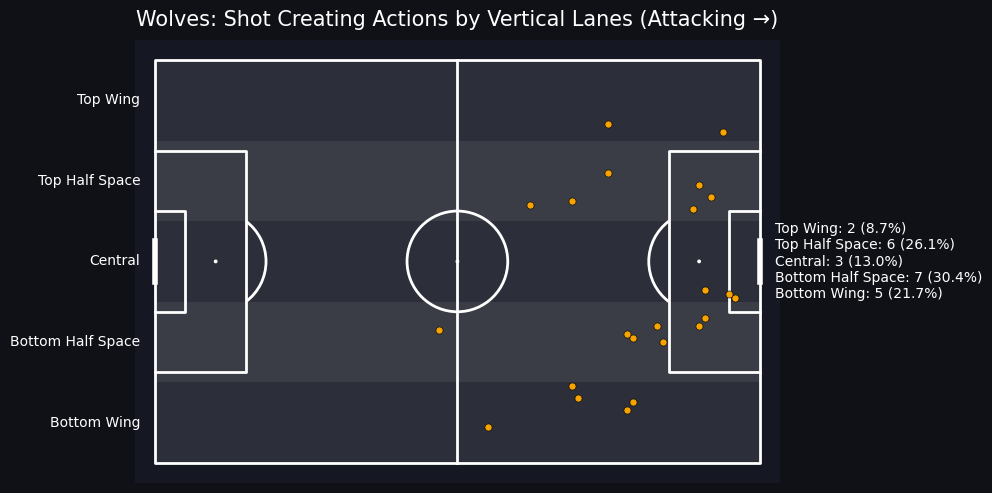

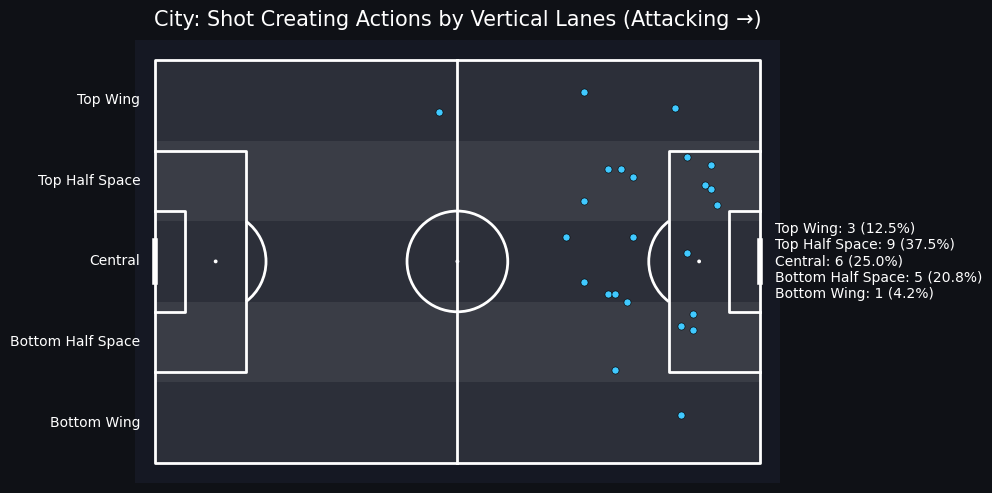

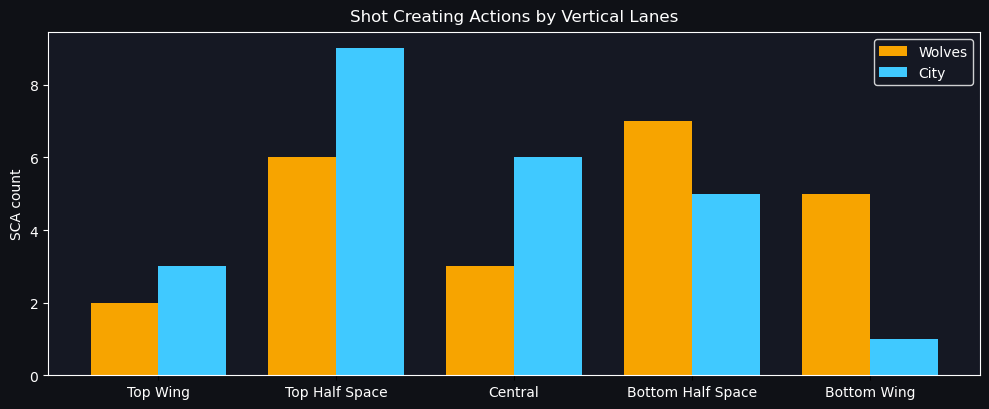

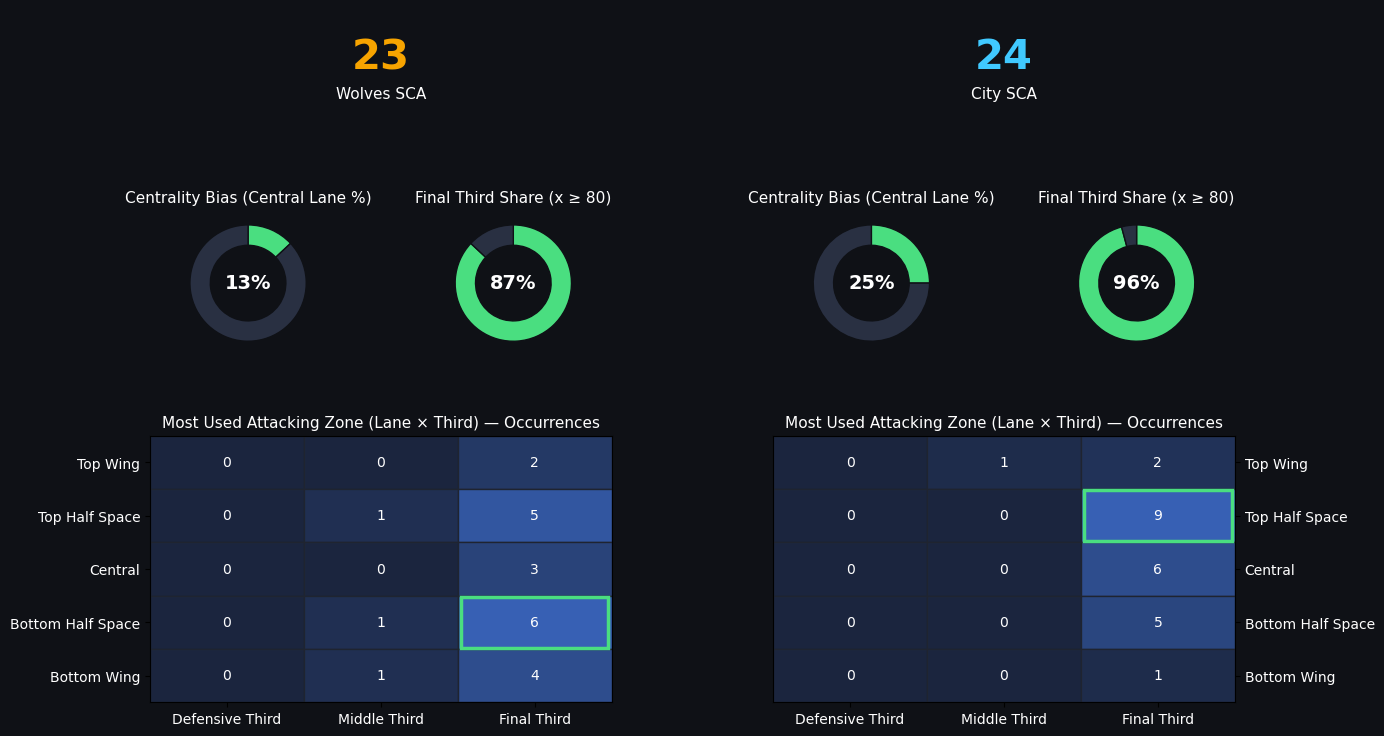

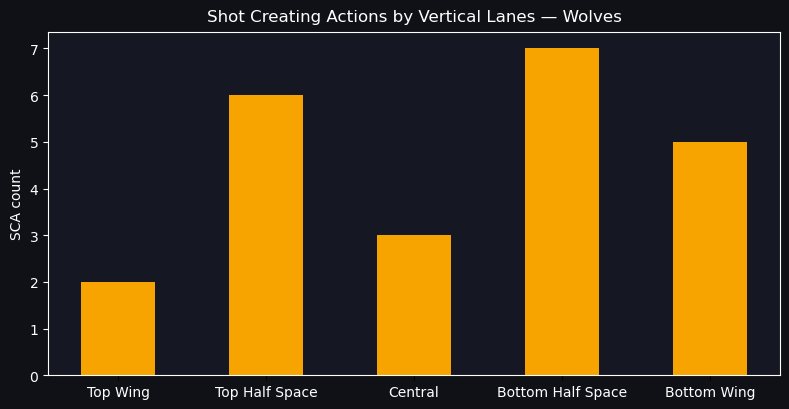

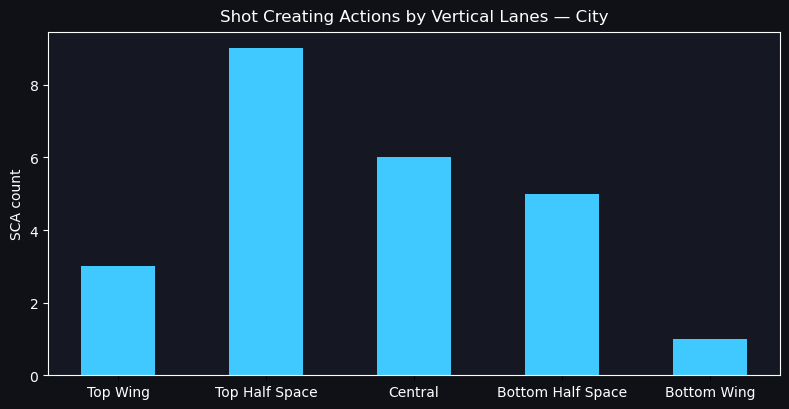

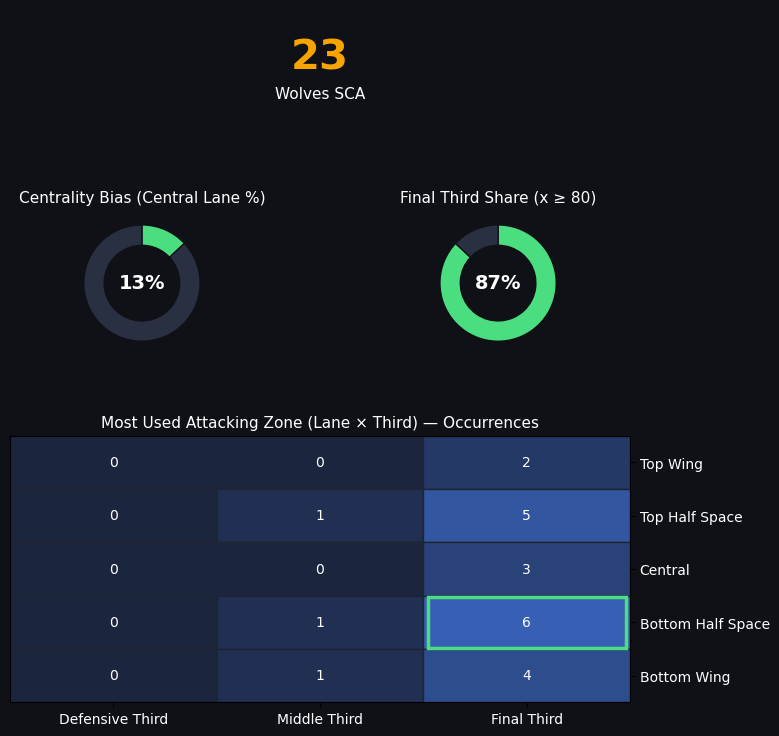

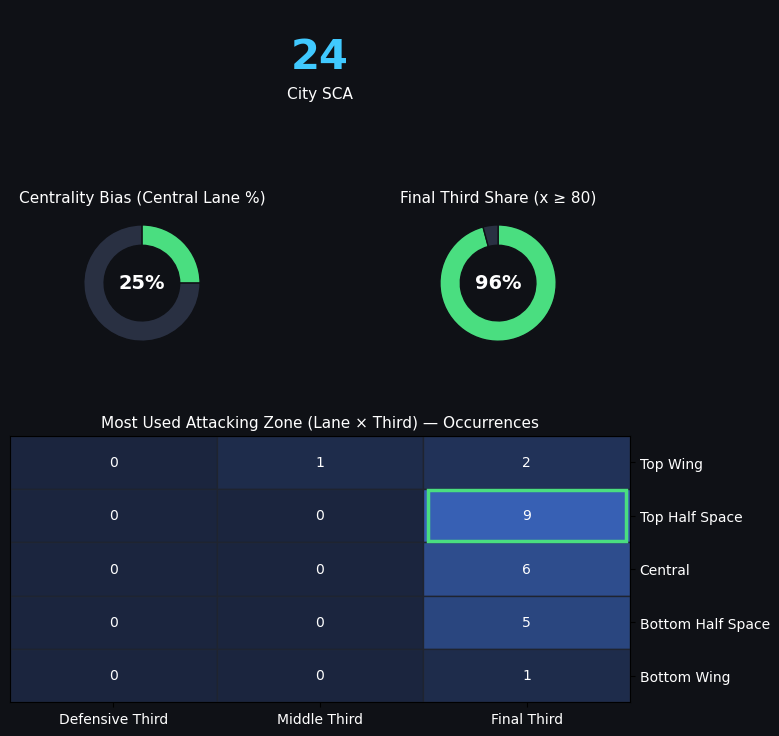

In [26]:
#!pip install mplsoccer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mplsoccer import Pitch

FILE = "prevGameSCA.xlsx"
SHEET = "Sheet1"

df = pd.read_excel(FILE, sheet_name=SHEET)

normalize = {
    "shot": "Shot", "shots": "Shot",
    "dribble": "Dribble", "dribbles": "Dribble",
    "cross": "Cross", "crosses": "Cross",
    "pass": "Pass", "passes": "Pass"
}
df["Event"] = df["Event"].astype(str).str.strip().str.lower().map(normalize).fillna(df["Event"])

df["X_sb"] = (df["X"].astype(float) * 1.2).clip(0, 120)
df["Y_sb"] = (df["Y"].astype(float) * 0.8).clip(0, 80)

wolves_df = df[df["Team"].str.strip().str.lower() == "wolves"].copy()
opp_df    = df[df["Team"].str.strip().str.lower() != "wolves"].copy()
opp_name  = opp_df["Team"].mode().iat[0] if not opp_df.empty else "Opponent"

wolves_df_flipped = wolves_df.copy()
wolves_df_flipped["X_sb"] = 120 - wolves_df_flipped["X_sb"]

LANE_NAMES  = ["Top Wing", "Top Half Space", "Central", "Bottom Half Space", "Bottom Wing"]
LANE_EDGES  = np.linspace(0, 80, 6)
THIRD_NAMES = ["Defensive Third", "Middle Third", "Final Third"]
THIRD_EDGES = [0, 40, 80, 120]

FIG_BG = "#0f1116"
AX_BG  = "#151823"
LINES  = "white"

def lane_from_y(y):
    return int(np.clip(np.digitize(y, LANE_EDGES, right=False) - 1, 0, 4))

def third_from_x(x):
    return int(np.clip(np.digitize(x, THIRD_EDGES, right=False) - 1, 0, 2))

def add_lane_label(ax, lane_idx, color="white"):
    y0, y1 = LANE_EDGES[lane_idx], LANE_EDGES[lane_idx+1]
    yc = (y0 + y1) / 2
    ax.text(-3, yc, LANE_NAMES[lane_idx], va="center", ha="right", color=color, fontsize=10)

def count_by_lane(df_in):
    if df_in.empty:
        return pd.Series(0, index=LANE_NAMES)
    lanes = df_in["Y_sb"].apply(lane_from_y)
    return (
        pd.Series(lanes)
        .value_counts()
        .reindex(range(5), fill_value=0)
        .rename(index=dict(enumerate(LANE_NAMES)))
        .astype(int)
    )

def plot_lanes_with_points(team_name, team_df, point_size=26, point_color="lightgreen"):
    pitch = Pitch(pitch_type="statsbomb", pitch_color=AX_BG, line_color=LINES)
    fig, ax = pitch.draw(figsize=(10, 7))
    fig.set_facecolor(FIG_BG)

    for i in range(5):
        y0, y1 = LANE_EDGES[i], LANE_EDGES[i+1]
        alpha = 0.10 if i % 2 == 0 else 0.16
        rect = Rectangle((0, y0), 120, y1 - y0, fc="white", ec=None, alpha=alpha, zorder=0)
        ax.add_patch(rect)
        add_lane_label(ax, i, color="white")

    if not team_df.empty:
        pitch.scatter(
            team_df["X_sb"], team_df["Y_sb"],
            ax=ax, s=point_size, c=point_color,
            edgecolors="black", linewidths=0.4, zorder=3
        )

    lane_counts = count_by_lane(team_df)
    total = int(len(team_df))
    lines = [f"{ln}: {int(c)} ({(c/total*100 if total else 0):.1f}%)" for ln, c in lane_counts.items()]
    ax.text(123, 40, "\n".join(lines), va="center", ha="left", color="white", fontsize=10)

    ax.set_title(f"{team_name}: Shot Creating Actions by Vertical Lanes (Attacking →)", color="white", fontsize=15, pad=10)
    plt.show()
    return lane_counts

def plot_lane_bars(wolves_counts, opp_counts, opp_label):
    idx = LANE_NAMES
    wc = wolves_counts.reindex(idx, fill_value=0).astype(int)
    oc = opp_counts.reindex(idx, fill_value=0).astype(int)
    x = np.arange(len(idx))
    width = 0.38
    fig, ax = plt.subplots(figsize=(10, 4.2), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)
    ax.bar(x - width/2, wc.values, width, label="Wolves", color="#f7a400")
    ax.bar(x + width/2, oc.values, width, label=opp_label, color="#40c9ff")
    ax.set_xticks(x)
    ax.set_xticklabels(idx, rotation=0, ha="center", color="white")
    ax.set_ylabel("SCA count", color="white")
    ax.tick_params(axis="y", colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    leg = ax.legend(facecolor=AX_BG, edgecolor="white")
    for text in leg.get_texts():
        text.set_color("white")
    ax.set_title("Shot Creating Actions by Vertical Lanes", color="white", pad=8)
    plt.tight_layout()
    plt.show()

def summary_components(team_df):
    total = int(len(team_df))
    if total == 0:
        return {
            "total": 0,
            "central_share": 0.0,
            "final_third_share": 0.0,
            "grid_counts": np.zeros((5, 3), dtype=int),
            "most_used": (2, 2)
        }
    lanes  = team_df["Y_sb"].apply(lane_from_y).to_numpy()
    thirds = team_df["X_sb"].apply(third_from_x).to_numpy()
    central_share = (lanes == 2).mean()
    final_third_share = (team_df["X_sb"] >= 80).mean()
    grid = np.zeros((5, 3), dtype=int)
    for l, t in zip(lanes, thirds):
        grid[l, t] += 1
    l_idx, t_idx = np.unravel_index(np.argmax(grid), grid.shape)
    return {
        "total": total,
        "central_share": float(central_share),
        "final_third_share": float(final_third_share),
        "grid_counts": grid,
        "most_used": (l_idx, t_idx)
    }

def donut(ax, share, title, label_inside=True):
    ax.set_facecolor(AX_BG)
    ax.pie(
        [share, 1 - share],
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35, edgecolor=FIG_BG),
        colors=["#4ade80", "#293042"],
    )
    if label_inside:
        ax.text(0, 0, f"{share*100:.0f}%", ha="center", va="center", color="white", fontsize=14, fontweight="bold")
    ax.set_title(title, color="white", fontsize=11, pad=6)

def big_metric(ax, value, title, color="#e5e7eb"):
    ax.set_facecolor(AX_BG)
    ax.axis("off")
    ax.text(0.5, 0.60, str(value), ha="center", va="center", color=color, fontsize=30, fontweight="bold")
    ax.text(0.5, 0.30, title, ha="center", va="center", color="white", fontsize=11)

def heatmap_zone(ax, grid_counts, highlight, title, y_labels_side="left",
                 highlight_inset=0.03, cell_width=1.4, cell_height=1.2):
    ax.set_facecolor(AX_BG)
    ax.set_title(title, color="white", fontsize=11, pad=6)
    n_rows, n_cols = grid_counts.shape
    total_width = n_cols * cell_width
    total_height = n_rows * cell_height
    ax.set_xticks([c * cell_width for c in range(n_cols)])
    ax.set_xticklabels(THIRD_NAMES, color="white", rotation=0)
    ax.set_yticks([r * cell_height for r in range(n_rows)])
    ax.set_yticklabels(LANE_NAMES, color="white")
    if y_labels_side == "right":
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', labelleft=False, labelright=True)
    else:
        ax.yaxis.tick_left()
        ax.yaxis.set_label_position("left")
        ax.tick_params(axis='y', labelright=False, labelleft=True)
    vmax = max(grid_counts.max(), 1)
    for i in range(n_rows):
        for j in range(n_cols):
            val = grid_counts[i, j]
            shade = 0.15 + 0.65 * (val / vmax)
            ax.add_patch(
                Rectangle((j * cell_width - cell_width/2,
                           i * cell_height - cell_height/2),
                          cell_width, cell_height,
                          facecolor=(0.25, 0.45, 0.85, shade),
                          edgecolor="#1f2430",
                          linewidth=1.0,
                          zorder=1)
            )
            ax.text(j * cell_width, i * cell_height, str(val),
                    ha="center", va="center", color="white", fontsize=10, zorder=2)
    li, tj = highlight
    x0 = (tj * cell_width - cell_width/2) + highlight_inset
    y0 = (li * cell_height - cell_height/2) + highlight_inset
    w  = cell_width - 2 * highlight_inset
    h  = cell_height - 2 * highlight_inset
    ax.add_patch(
        Rectangle((x0, y0), w, h,
                  fill=False,
                  edgecolor="#4ade80",
                  linewidth=2.5,
                  zorder=10,
                  snap=True)
    )
    ax.set_xlim(-cell_width/2, total_width - cell_width/2)
    ax.set_ylim(total_height - cell_height/2, -cell_height/2)
    ax.grid(False)

def plot_summary_dashboard(w_sum, o_sum, opp_label):
    fig = plt.figure(figsize=(14, 9), facecolor=FIG_BG)
    gs = fig.add_gridspec(
        3, 2,
        height_ratios=[1.0, 1.2, 2.2],
        hspace=0.45,
        wspace=0.35
    )
    ax_w_total = fig.add_subplot(gs[0, 0])
    big_metric(ax_w_total, w_sum["total"], "Wolves SCA", color="#f7a400")
    ax_o_total = fig.add_subplot(gs[0, 1])
    big_metric(ax_o_total, o_sum["total"], f"{opp_label} SCA", color="#40c9ff")
    sub_w = gs[1, 0].subgridspec(1, 2, wspace=0.35)
    sub_o = gs[1, 1].subgridspec(1, 2, wspace=0.35)
    ax_w_central = fig.add_subplot(sub_w[0, 0])
    donut(ax_w_central, w_sum["central_share"], "Centrality Bias (Central Lane %)")
    ax_w_final = fig.add_subplot(sub_w[0, 1])
    donut(ax_w_final, w_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    ax_o_central = fig.add_subplot(sub_o[0, 0])
    donut(ax_o_central, o_sum["central_share"], "Centrality Bias (Central Lane %)")
    ax_o_final = fig.add_subplot(sub_o[0, 1])
    donut(ax_o_final, o_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    ax_w_heat = fig.add_subplot(gs[2, 0])
    heatmap_zone(ax_w_heat, w_sum["grid_counts"], w_sum["most_used"],
                 "Most Used Attacking Zone (Lane × Third) — Occurrences",
                 y_labels_side="left")
    ax_o_heat = fig.add_subplot(gs[2, 1])
    heatmap_zone(ax_o_heat, o_sum["grid_counts"], o_sum["most_used"],
                 "Most Used Attacking Zone (Lane × Third) — Occurrences",
                 y_labels_side="right")
    plt.show()

def plot_lane_bars_single(counts, label, color):
    idx = LANE_NAMES
    c = counts.reindex(idx, fill_value=0).astype(int)
    x = np.arange(len(idx))
    fig, ax = plt.subplots(figsize=(8, 4.2), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)
    ax.bar(x, c.values, 0.5, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(idx, rotation=0, ha="center", color="white")
    ax.set_ylabel("SCA count", color="white")
    ax.tick_params(axis="y", colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_title(f"Shot Creating Actions by Vertical Lanes — {label}", color="white", pad=8)
    plt.tight_layout()
    plt.show()

def plot_summary_dashboard_single(s_sum, label, color):
    fig = plt.figure(figsize=(8, 9), facecolor=FIG_BG)
    gs = fig.add_gridspec(3, 1, height_ratios=[1.0, 1.2, 2.2], hspace=0.45)
    ax_total = fig.add_subplot(gs[0, 0])
    big_metric(ax_total, s_sum["total"], f"{label} SCA", color=color)
    sub = gs[1, 0].subgridspec(1, 2, wspace=0.35)
    ax_central = fig.add_subplot(sub[0, 0])
    donut(ax_central, s_sum["central_share"], "Centrality Bias (Central Lane %)")
    ax_final = fig.add_subplot(sub[0, 1])
    donut(ax_final, s_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    ax_heat = fig.add_subplot(gs[2, 0])
    heatmap_zone(ax_heat, s_sum["grid_counts"], s_sum["most_used"], "Most Used Attacking Zone (Lane × Third) — Occurrences", y_labels_side="right")
    plt.show()

wolves_lane_counts = plot_lanes_with_points("Wolves", wolves_df_flipped, point_color="#f7a400")
opp_lane_counts    = plot_lanes_with_points(opp_name, opp_df, point_color="#40c9ff")
plot_lane_bars(wolves_lane_counts, opp_lane_counts, opp_label=opp_name)

wolves_sum = summary_components(wolves_df_flipped)
opp_sum    = summary_components(opp_df)

plot_summary_dashboard(wolves_sum, opp_sum, opp_label=opp_name)

plot_lane_bars_single(wolves_lane_counts, "Wolves", "#f7a400")
plot_lane_bars_single(opp_lane_counts, opp_name, "#40c9ff")

plot_summary_dashboard_single(wolves_sum, "Wolves", "#f7a400")
plot_summary_dashboard_single(opp_sum, opp_name, "#40c9ff")
